In [203]:
import os
from scipy.signal import spectrogram
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.colors import Normalize

In [205]:
audio_folder = './Downloads/uuvx/'
output_folder = './Downloads/uuvx_spectogram'
os.makedirs(output_folder,exist_ok=True)

In [207]:
freq_min = 10
freq_max = 2500
window_size = 1024
overlap = 800
n_fft = 1024*4 # 2^10


In [209]:
for file in os.listdir(audio_folder):
    if not file.lower().endswith('.wav'):
        continue 
        
    file_path = os.path.join(audio_folder, file)
    #print(file_path)
    fs,x=wavfile.read(file_path)
    
    if x.ndim > 1:
        x = np.mean(x, axis =1)
                      
    f, t, S = spectrogram(x,fs,nperseg=window_size, noverlap=overlap, nfft=n_fft)
    f_mask=(f>=freq_min)&(f<=freq_max)
    sxx=S[f_mask,:]
    G = 10*np.log10(sxx+1e-8)
    norm = Normalize(vmin= np.min(G),vmax = np.max(G))
    G_normalized = norm(G)
    G_colormap = plt.cm.jet( G_normalized)
    G_image = ( G_colormap[:,:,:3]*255).astype(np.uint8)
    G_resized= Image.fromarray(G_image).resize((224,224))
    output_file = os.path.join(output_folder,os.path.basename(file_path).replace('.wav','.png'))
    G_resized.save(  output_file)

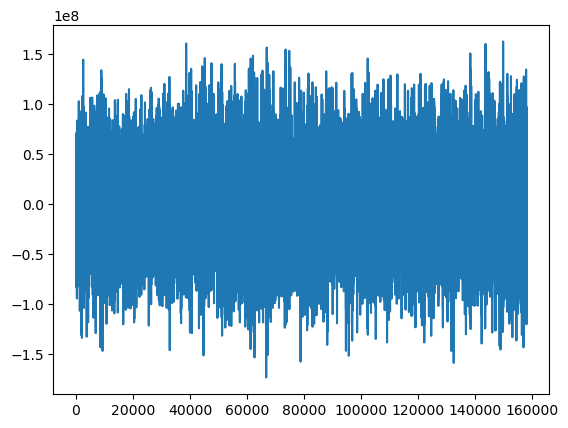

In [210]:
plt.plot(x)

In [211]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


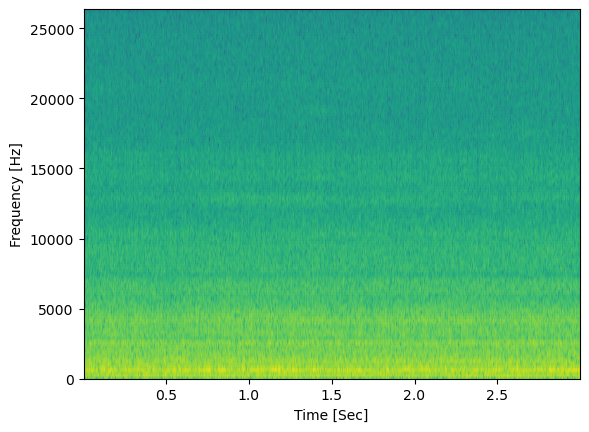

In [213]:
f,t,Sxx = spectrogram(x, fs)
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Sec]')
plt.show()

In [214]:
audio_folder = './Downloads/Kai/'

In [215]:
for file in os.listdir(audio_folder):
    if not file.lower().endswith('.wav'):
        continue 
        
    file_path = os.path.join(audio_folder, file)
    #print(file_path)
    fs,x=wavfile.read(file_path)
    
    if x.ndim > 1:
        x = np.mean(x, axis =1)
                      
    f, t, S = spectrogram(x,fs,nperseg=window_size, noverlap=overlap, nfft=n_fft)
    f_mask=(f>=freq_min)&(f<=freq_max)
    sxx=S[f_mask,:]
    G = 10*np.log10(sxx+1e-8)
    norm = Normalize(vmin= np.min(G),vmax = np.max(G))
    G_normalized = norm(G)
    G_colormap = plt.cm.jet( G_normalized)
    G_image = ( G_colormap[:,:,:3]*255).astype(np.uint8)
    G_resized= Image.fromarray(G_image).resize((224,224))
    output_file = os.path.join(output_folder,os.path.basename(file_path).replace('.wav','.png'))
    G_resized.save(  output_file)

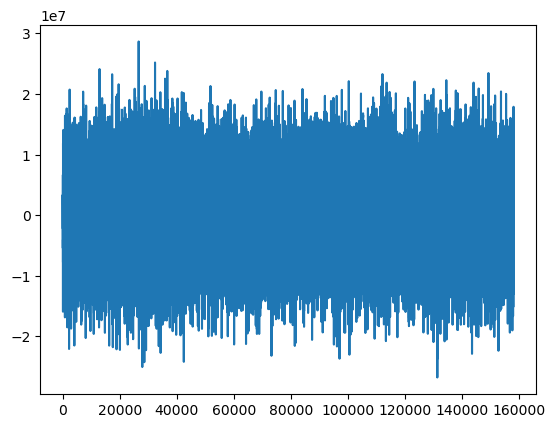

In [216]:
plt.plot(x)

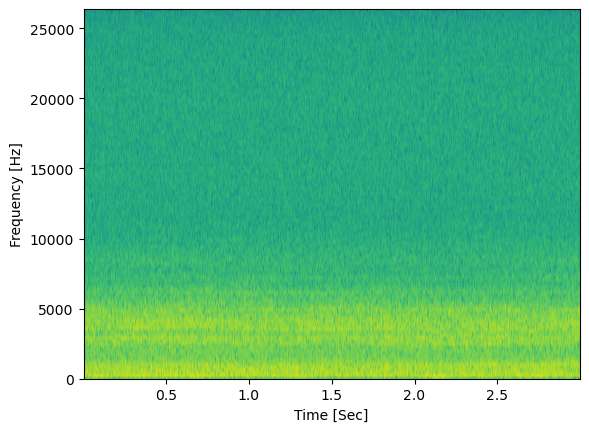

In [217]:
f,t,Sxx = spectrogram(x, fs)
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [Sec]')
plt.show()

In [218]:
# nn Model
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

In [219]:
data_dir = './Downloads/Data_F/'
batch_size = 8
num_epochs = 10
learning_rate = 0.001
num_classes = 4
print (num_classes)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

4


In [220]:
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "Train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "Val"), transform=transform)

In [221]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

In [222]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.model = models.vit_b_32(pretrained=True)
        in_features = self.model.heads.head.in_features
        self.model.heads.head = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

In [223]:
class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [224]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit_model = ViTModel(num_classes).to(device)
efficientnet_model = EfficientNetModel(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.Adam(vit_model.parameters(), lr = learning_rate)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr = learning_rate)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to ge

In [225]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs, model_name):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Training {model_name} Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs,1)
                total += labels.size(0)
                correct += (predicted ==labels).sum().item()

        val_loss /= len(val_loader.dataset)
        accuracy = correct / total * 100

        print(f"{model_name} Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
             f"Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

In [227]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classification_head = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), 224, -1)  
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        return self.classification_head(x)


In [229]:
transformer_model = TransformerClassifier(input_dim=224*3, model_dim=256, num_heads=8, num_layers=4, num_classes=num_classes).to(device)
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=learning_rate)

print("\nTraining Transformer Model:")
train_model(transformer_model, transformer_optimizer, train_loader, val_loader, num_epochs, "Transformer")



Training Transformer Model:


Training Transformer Epoch 1/10: 100%|████████| 439/439 [01:46<00:00,  4.13it/s]


Transformer Epoch 1/10, Train Loss: 0.9263, Val Loss: 1.0288, Val Accuracy: 56.86%


Training Transformer Epoch 2/10: 100%|████████| 439/439 [01:43<00:00,  4.23it/s]


Transformer Epoch 2/10, Train Loss: 0.8941, Val Loss: 1.0836, Val Accuracy: 56.86%


Training Transformer Epoch 3/10: 100%|████████| 439/439 [01:45<00:00,  4.17it/s]


Transformer Epoch 3/10, Train Loss: 0.8922, Val Loss: 1.0673, Val Accuracy: 56.86%


Training Transformer Epoch 4/10: 100%|████████| 439/439 [01:42<00:00,  4.26it/s]


Transformer Epoch 4/10, Train Loss: 0.8885, Val Loss: 1.0121, Val Accuracy: 56.86%


Training Transformer Epoch 5/10: 100%|████████| 439/439 [01:44<00:00,  4.21it/s]


Transformer Epoch 5/10, Train Loss: 0.8849, Val Loss: 1.0083, Val Accuracy: 56.86%


Training Transformer Epoch 6/10: 100%|████████| 439/439 [01:44<00:00,  4.20it/s]


Transformer Epoch 6/10, Train Loss: 0.8845, Val Loss: 1.0455, Val Accuracy: 56.86%


Training Transformer Epoch 7/10: 100%|████████| 439/439 [01:45<00:00,  4.17it/s]


Transformer Epoch 7/10, Train Loss: 0.8889, Val Loss: 1.0399, Val Accuracy: 56.86%


Training Transformer Epoch 8/10: 100%|████████| 439/439 [01:44<00:00,  4.21it/s]


Transformer Epoch 8/10, Train Loss: 0.8833, Val Loss: 1.0155, Val Accuracy: 56.86%


Training Transformer Epoch 9/10: 100%|████████| 439/439 [01:45<00:00,  4.15it/s]


Transformer Epoch 9/10, Train Loss: 0.8851, Val Loss: 1.0111, Val Accuracy: 56.86%


Training Transformer Epoch 10/10: 100%|███████| 439/439 [01:46<00:00,  4.14it/s]


Transformer Epoch 10/10, Train Loss: 0.8828, Val Loss: 1.0670, Val Accuracy: 56.86%


Precision: 0.3233, Recall: 0.5686, F1 Score: 0.4122


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


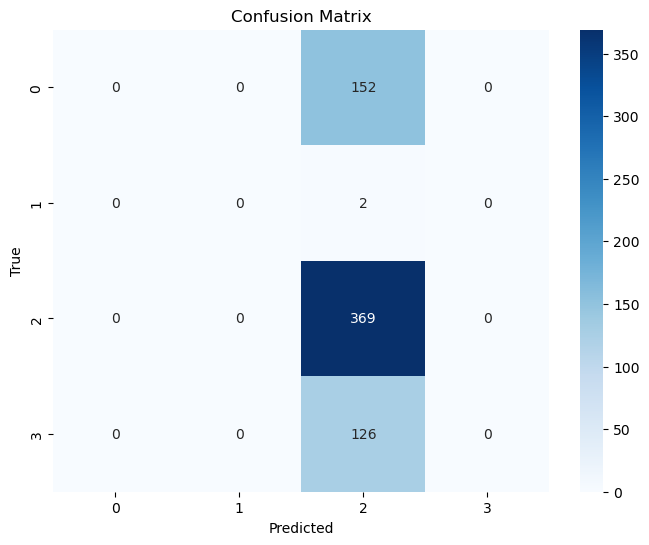

In [230]:
evaluate_model(transformer_model, val_loader)

In [231]:
vit_model = ViTModel(num_classes=num_classes).to(device)
vit_optimizer = optim.Adam(vit_model.parameters(), lr=learning_rate)

print("\nTraining ViT Model:")
train_model(vit_model, vit_optimizer, train_loader, val_loader, num_epochs, "Vision Transformer")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training ViT Model:


Training Vision Transformer Epoch 1/10: 100%|█| 439/439 [02:31<00:00,  2.90it/s]


Vision Transformer Epoch 1/10, Train Loss: 0.9465, Val Loss: 1.1261, Val Accuracy: 56.86%


Training Vision Transformer Epoch 2/10: 100%|█| 439/439 [02:31<00:00,  2.91it/s]


Vision Transformer Epoch 2/10, Train Loss: 0.8872, Val Loss: 1.0447, Val Accuracy: 56.86%


Training Vision Transformer Epoch 3/10: 100%|█| 439/439 [02:32<00:00,  2.89it/s]


Vision Transformer Epoch 3/10, Train Loss: 0.8818, Val Loss: 1.0355, Val Accuracy: 56.86%


Training Vision Transformer Epoch 4/10: 100%|█| 439/439 [02:32<00:00,  2.87it/s]


Vision Transformer Epoch 4/10, Train Loss: 0.8698, Val Loss: 1.1253, Val Accuracy: 56.86%


Training Vision Transformer Epoch 5/10: 100%|█| 439/439 [02:32<00:00,  2.89it/s]


Vision Transformer Epoch 5/10, Train Loss: 0.8638, Val Loss: 1.1919, Val Accuracy: 55.62%


Training Vision Transformer Epoch 6/10: 100%|█| 439/439 [02:33<00:00,  2.86it/s]


Vision Transformer Epoch 6/10, Train Loss: 0.8450, Val Loss: 1.0226, Val Accuracy: 56.86%


Training Vision Transformer Epoch 7/10: 100%|█| 439/439 [02:31<00:00,  2.90it/s]


Vision Transformer Epoch 7/10, Train Loss: 0.8351, Val Loss: 1.0668, Val Accuracy: 57.01%


Training Vision Transformer Epoch 8/10: 100%|█| 439/439 [02:31<00:00,  2.91it/s]


Vision Transformer Epoch 8/10, Train Loss: 0.7624, Val Loss: 1.0163, Val Accuracy: 67.64%


Training Vision Transformer Epoch 9/10: 100%|█| 439/439 [02:32<00:00,  2.88it/s]


Vision Transformer Epoch 9/10, Train Loss: 0.7423, Val Loss: 0.8465, Val Accuracy: 70.88%


Training Vision Transformer Epoch 10/10: 100%|█| 439/439 [02:30<00:00,  2.91it/s


Vision Transformer Epoch 10/10, Train Loss: 0.6878, Val Loss: 0.9200, Val Accuracy: 66.10%


Precision: 0.5312, Recall: 0.6610, F1 Score: 0.5854


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


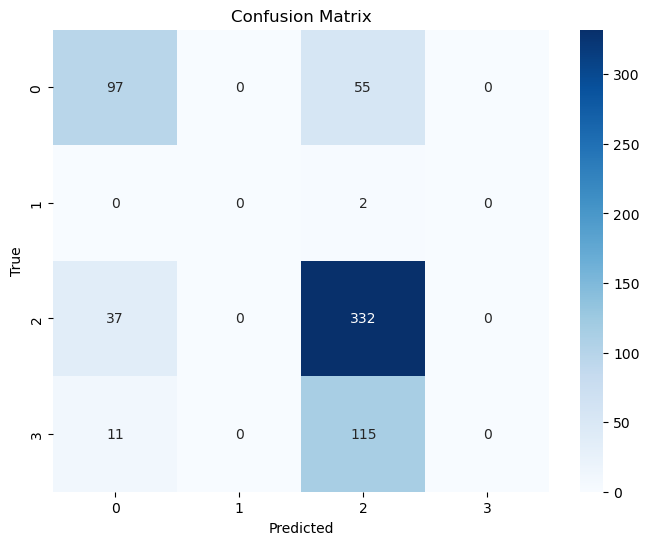

In [232]:
evaluate_model(vit_model, val_loader)

In [ ]:
efficientnet_model = EfficientNetModel(num_classes=num_classes).to(device)
efficientnet_optimizer = optim.Adam(efficientnet_model.parameters(), lr=learning_rate)

print("\nTraining EfficientNet Model:")
train_model(efficientnet_model, efficientnet_optimizer, train_loader, val_loader, num_epochs, "EfficientNet")

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training EfficientNet Model:


Training EfficientNet Epoch 1/10: 100%|███████| 439/439 [05:48<00:00,  1.26it/s]


EfficientNet Epoch 1/10, Train Loss: 0.7329, Val Loss: 0.9353, Val Accuracy: 60.55%


Training EfficientNet Epoch 2/10: 100%|███████| 439/439 [05:47<00:00,  1.26it/s]


EfficientNet Epoch 2/10, Train Loss: 0.4979, Val Loss: 1.0684, Val Accuracy: 72.57%


Training EfficientNet Epoch 3/10: 100%|███████| 439/439 [05:46<00:00,  1.27it/s]


EfficientNet Epoch 3/10, Train Loss: 0.4019, Val Loss: 1.7801, Val Accuracy: 46.84%


Training EfficientNet Epoch 4/10: 100%|███████| 439/439 [05:46<00:00,  1.27it/s]


EfficientNet Epoch 4/10, Train Loss: 0.3444, Val Loss: 1.4466, Val Accuracy: 54.70%


Training EfficientNet Epoch 5/10: 100%|███████| 439/439 [05:49<00:00,  1.26it/s]


EfficientNet Epoch 5/10, Train Loss: 0.3117, Val Loss: 1.5745, Val Accuracy: 47.15%


Training EfficientNet Epoch 6/10: 100%|███████| 439/439 [05:50<00:00,  1.25it/s]


EfficientNet Epoch 6/10, Train Loss: 0.2946, Val Loss: 2.6101, Val Accuracy: 41.29%


Training EfficientNet Epoch 7/10:  46%|███▏   | 203/439 [02:42<03:06,  1.26it/s]

In [ ]:
evaluate_model(efficientnet_model, val_loader)

In [ ]:
#Discuss which model performed better and why.
# From this project we can conclude that both the transformer and cnn models preformed similarly, however
# the cnn model were slightly better in comparison. The model that preformed the best was  EfficientNet
# with the highest accuracy score of 72 % and a loss of 0.3444. EfficientNet should preform the best 
# due to its faster processing speed and the pretrained data set, b0 that was used. 

In [ ]:
#Discuss the role of spectrograms in this classification task.

# Spectrograms were used for classification as they allowed us to transform audiofiles into computer readable images
# in turn allowing for the learning models to understand the audio better and analyze the pngs for detectable patterns
# such as frequencies and the changes of amplitude 

In [ ]:
#Reflect on the challenges faced in preprocessing, model training, and evaluation.
#Provide recommendations for future work, including possible enhancements to the models

# I had difficulty converting all the .wav files into spectrograms, so I opted to do them manually, however I could not get the SpeedBoat
# file to open fully, So i opted to reduce it from 10k audio files to 500, also it seems that the noise_target file only had 2 .WAV files
# so I included both in testing and validation. Model training was very slow taking around 3-4 hours after repea
One idea to enhance this model would be to add an additonal feature to increase accuracy.